# Code

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn import preprocessing

import re

/Users/romeo/anaconda/envs/aging3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def signal_pca(signal, title, scale=True, ax=None, custom_group=None):
    pca = PCA(n_components=2)
    X = preprocessing.scale(signal) if scale else signal
    X_r = pca.fit_transform(X)
    
    pc1_var, pc2_var = pca.explained_variance_ratio_
    print("PCA components: ", X_r.shape)
    xlabel = "PC1{} ({:.2%})".format(" [not scaled]" if not scale else "", pc1_var)
    ylabel = "PC2{} ({:.2%})".format(" [not scaled]" if not scale else "", pc2_var)

    if custom_group:
        gr1_mask = [l in custom_group for l in signal.index]
        gr2_mask = [l not in custom_group for l in signal.index]
    else:
        gr1_mask = signal.index.str.startswith('OD')
        gr2_mask = signal.index.str.startswith('YD')
    
#     print("Gr1 group: ", ",\n".join(signal.index[gr1_mask]))
#     print("Gr2 group: ", ",\n".join(signal.index[gr2_mask]))
    
    is_separate_plot = ax is None
    if is_separate_plot:
        plt.figure(figsize=(7,7))
        ax=plt.subplot()

    ax.scatter(X_r[gr1_mask, 0], X_r[gr1_mask, 1] , color='blue', alpha=.8, 
               label='OD' if not custom_group else "Group 1")
    ax.scatter(X_r[gr2_mask, 0], X_r[gr2_mask, 1] , color='red', alpha=.8,
               label='YD' if not custom_group else "Group 2")
    
    for j, m in enumerate([gr1_mask, gr2_mask]):
        for i, label in enumerate(re.sub('_R1.*', '', l) for l in signal.index):
            if m[i]:
                ax.annotate(label, xy=(X_r[i, 0], X_r[i, 1]), 
                             fontsize=9, xytext=(5, 0),
                             color = "blue" if j == 0 else "red",
                             textcoords='offset points' #ha='right', va='bottom'
                            )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='best', shadow=False)

    if is_separate_plot:
        plt.show()

In [3]:
import numpy.random as rnd

def random_donors_split(data, donors, score_f, sizes, n_iter = 9, seed=10):
    rnd.seed(seed)

    labels = list(donors)
    half_idx = len(labels) // 2
    
    plt.figure(figsize=(2*6, n_iter*6))
    
    for i in range(n_iter):
        rnd.shuffle(labels)
        rnd_gr1 = labels[0:half_idx]
        rnd_gr2 = labels[half_idx:]

        print("======================== {}/{} ======================== ".format(i, n_iter))
#         print("  Group #1", ", \n".join(rnd_gr1))
#         print("  Group #2", ", \n".join(rnd_gr2))

        signal = pd.concat((score_f(data, rnd_gr1, OD_input, sizes), 
                            score_f(data, rnd_gr2, YD_input, sizes)), axis=1)
        signal = signal.loc[:, sorted(signal.columns)]
        signal = signal.T

        gr1_OD_count = np.sum([l.startswith('OD') for l in rnd_gr1])
        gr2_OD_count = np.sum([l.startswith('OD') for l in rnd_gr2])

        title = "#{} 1.([O:{}, Y:{}], ODS-Input) 2.([O:{}, Y:{}], YDS-Input)".format(
            i+1, 
            gr1_OD_count, len(rnd_gr1) - gr1_OD_count,
            gr2_OD_count, len(rnd_gr2) - gr2_OD_count
        )
        
        # highlight by group
        signal_pca(signal, title, custom_group=rnd_gr1, ax=plt.subplot(n_iter, 2, 2*i + 1))
        
        # higlight by age
        signal_pca(signal, title, custom_group=None, ax=plt.subplot(n_iter, 2, 2*i + 2))

In [4]:
def split_by_age(data, *outliers):
    def is_outlier(col):
        if not outliers:
            return False
        return any(col.startswith(o) for o in outliers)
        
    ODS = sorted([c for c in data.columns.tolist() if c.startswith("OD") and ("input" not in c) and not is_outlier(c)])
    YDS = sorted([c for c in data.columns.tolist() if c.startswith("YD") and ("input" not in c) and not is_outlier(c)])
    
    return ODS, YDS, ODS+YDS

# RPM Simple Score: RPM(donor, age) - RPM(input, age)

Sligth separation on PCA

In [5]:
# file_id = "YO_macs_broad_0.1_150"
file_id = "PEAKS_UCSC_CGI"

rpm_path = "/Users/romeo/tmp/artyomov_lab_aging/k4me1/k4me1_20vs20_reseq_bams_unique/coverages/{0}/{0}_rpm.tsv".format(file_id)
rpms = pd.read_csv(rpm_path, sep="\t")

OD_input = "OD_input_unique"
YD_input = "YD_input_unique"

## Code

In [6]:
# data - Data df: ranges x donors
# donor_cols - required donors columns names
# input_col - column name with input
# args - unused args
def make_rpkm_diff_score(data, donor_cols, input_col, *args):    
    i_data = data[input_col]
    
    df = pd.DataFrame()
    for d in donor_cols:
        scores = data[d] - i_data
        scores[scores < 0] = 0
        min_s = scores.min()
        df[d] = (scores - min_s) / (scores.max() - min_s)

    return df   

Let's take ** score ** just: rpm(donor, age, i) - rpm(input, age)

## Score Histogram

In [7]:
def describe_score(donor, donor_input, rpms):
    donor_minus_input = rpms[donor] - rpms[donor_input]
    donor_score = donor_minus_input.copy()
    donor_score[donor_score < 0] = 0
    donor_score_norm = (donor_score - donor_score.min()) / (donor_score.max() - donor_score.min())

    plt.figure(figsize=(10,10))

    ax = plt.subplot(2,2,1)
    ax.hist(donor_minus_input, bins=100)
    ax.set_title("{} - Input".format(donor))
    #ax.set_xscale("log")

    ax = plt.subplot(2,2,3)
    ax.hist(donor_score, bins=100)
    ax.set_title("Scores".format(donor))
    ax.set_xscale("log")

    ax = plt.subplot(2,2,4)
    ax.hist(donor_score_norm, bins=100)
    ax.set_title("Lin. norm scores".format(donor))
    ax.set_xscale("log")

    plt.show()
    

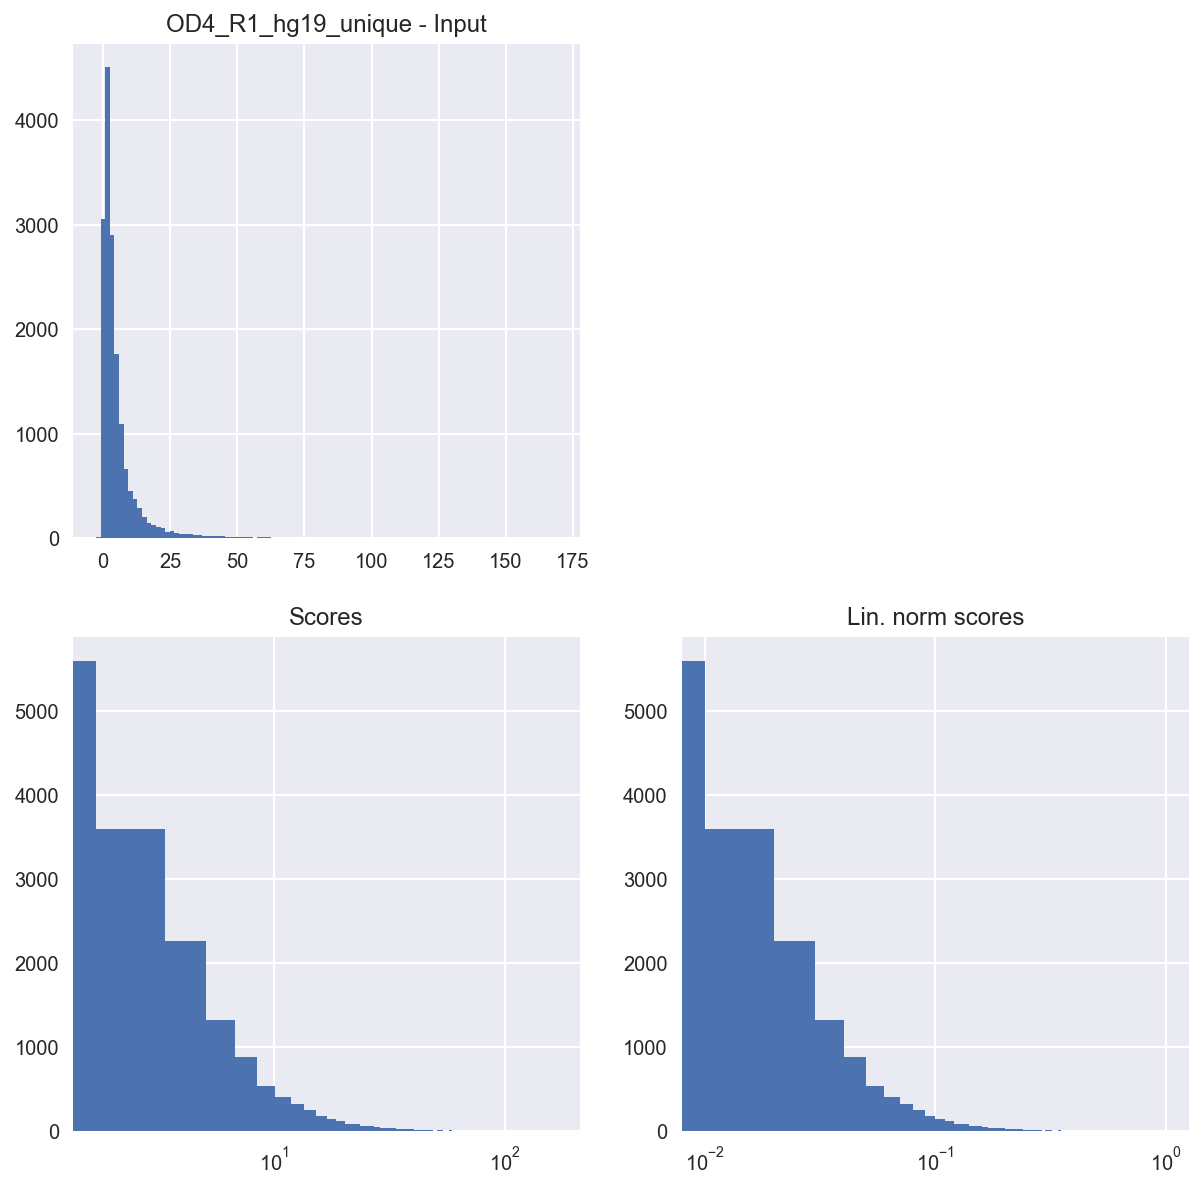

In [8]:
# OD4 as example
describe_score("OD4_R1_hg19_unique", "OD_input_unique", rpms)

## PCA

PCA components:  (32, 2)


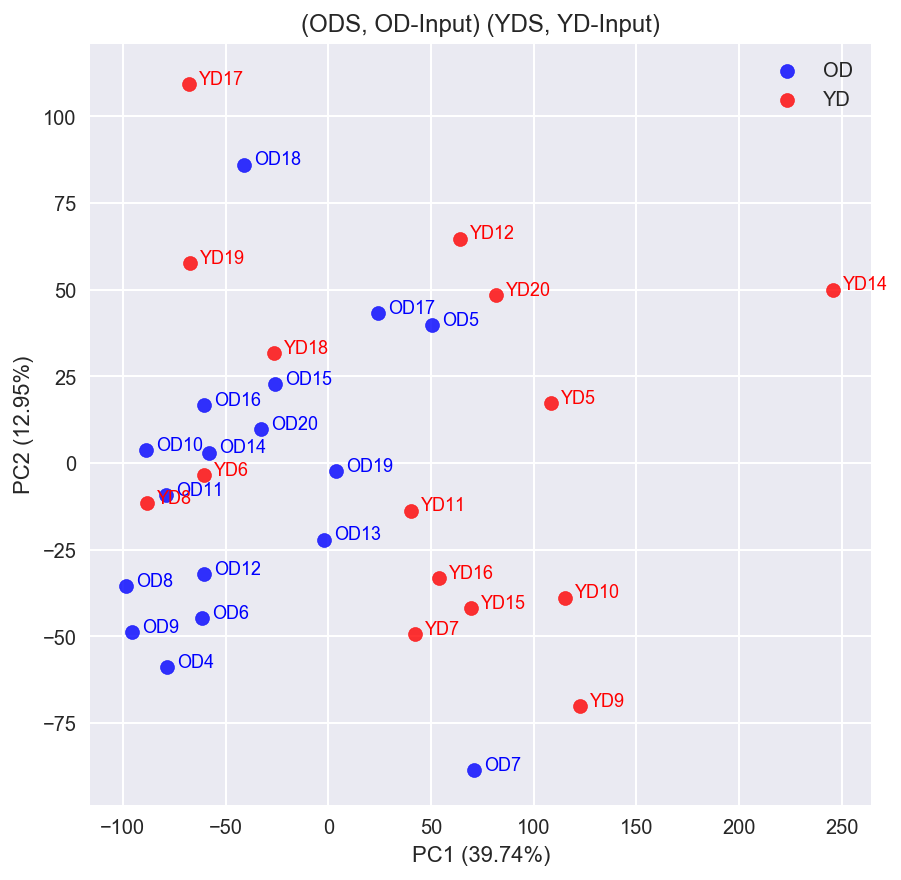

PCA components:  (32, 2)


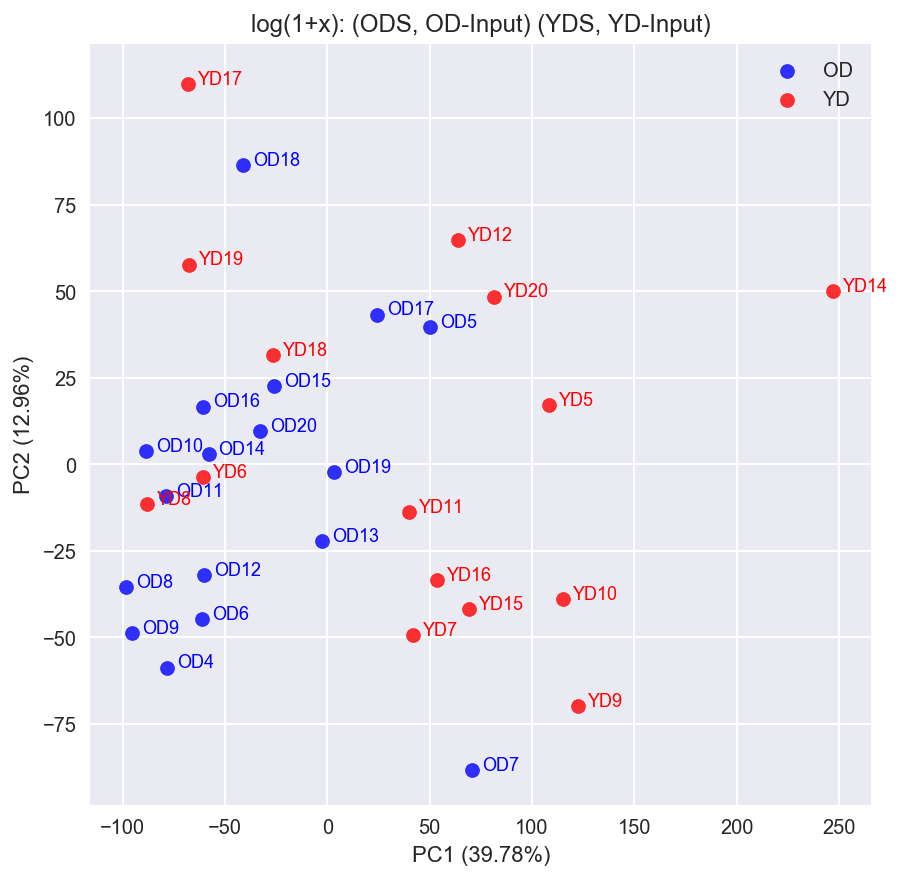

In [9]:
# all donors
ODS, YDS, OYDS = split_by_age(rpms)
signal = pd.concat((make_rpkm_diff_score(rpms, ODS, OD_input), 
                    make_rpkm_diff_score(rpms, YDS, YD_input)), axis=1)
signal_pca(signal.T, "(ODS, OD-Input) (YDS, YD-Input)")
signal_pca(np.log1p(signal.T), "log(1+x): (ODS, OD-Input) (YDS, YD-Input)")

PCA components:  (31, 2)


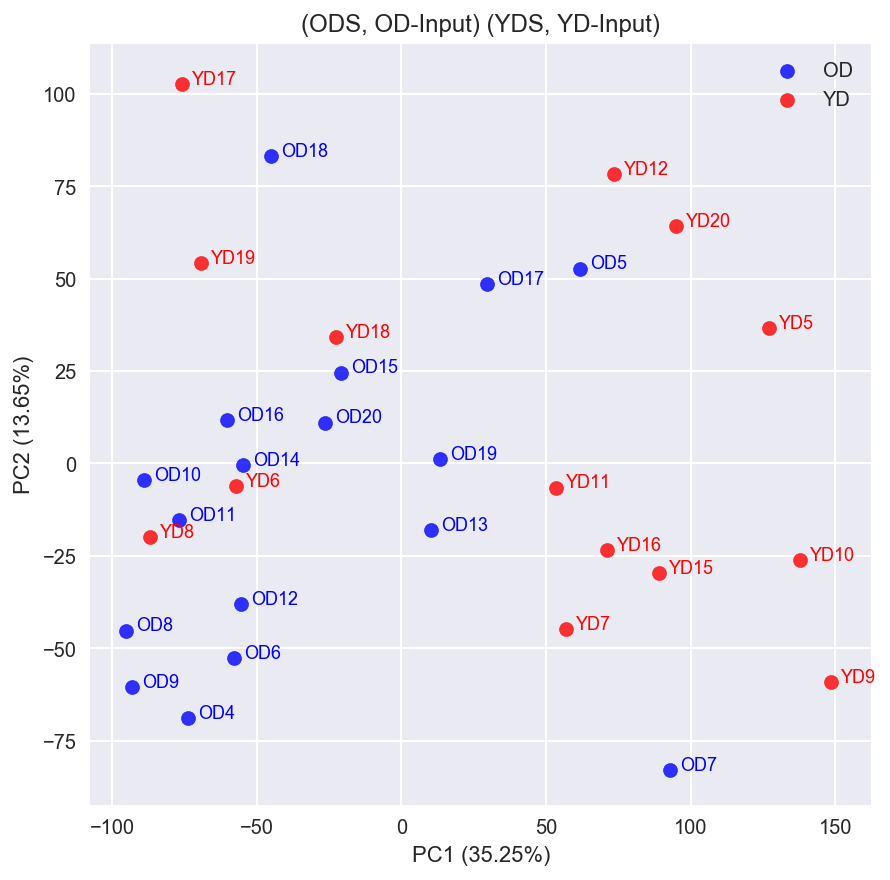

In [10]:
# w/o Y14
ODS, YDS, OYDS = split_by_age(rpms, "YD14")
signal = pd.concat((make_rpkm_diff_score(rpms, ODS, OD_input), 
                    make_rpkm_diff_score(rpms, YDS, YD_input)), axis=1)
signal_pca(signal.T, "(ODS, OD-Input) (YDS, YD-Input)")

## PCA: Swap Y<->O Input

Now let's change O <-> Y input:

PCA components:  (32, 2)


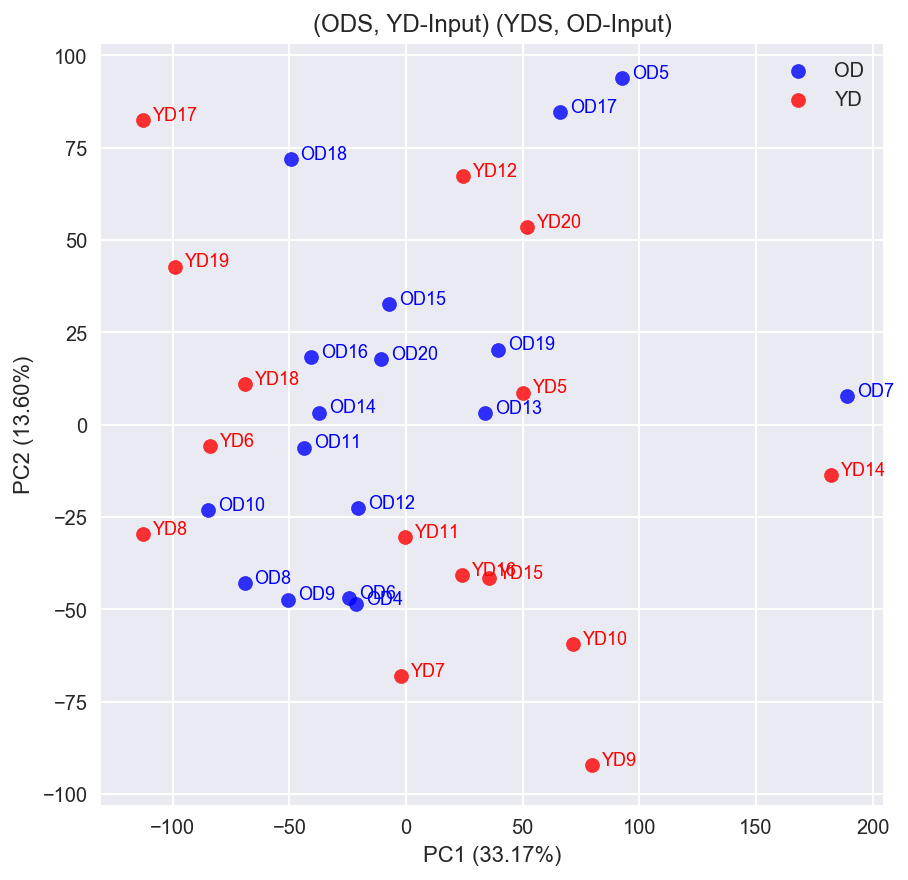

In [11]:
ODS, YDS, OYDS = split_by_age(rpms)
signal = pd.concat((make_rpkm_diff_score(rpms, ODS, YD_input), 
                    make_rpkm_diff_score(rpms, YDS, OD_input)), axis=1).T

signal_pca(signal, "(ODS, YD-Input) (YDS, OD-Input)")

Now let's take mean input(ODS, YDS)

## PCA: Mean (OD Input, YD input)

PCA components:  (32, 2)


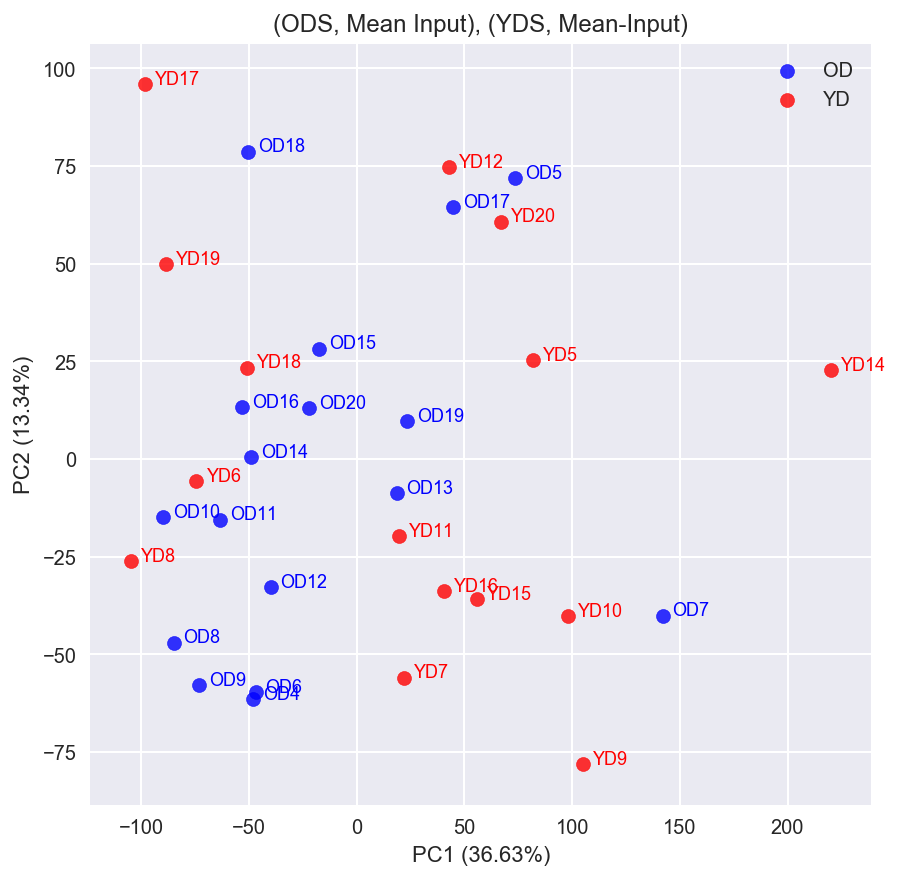

PCA components:  (32, 2)


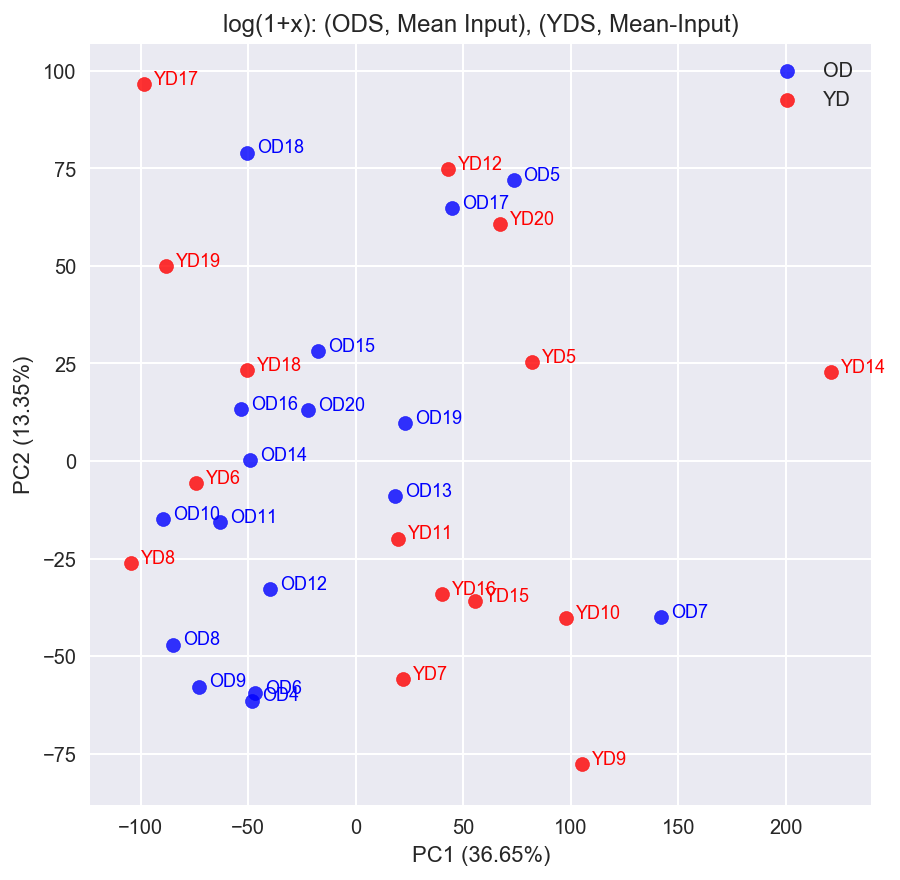

In [12]:
ODS, YDS, OYDS = split_by_age(rpms)

OY_mean_input = 'OYD_mean_input_unique'
rpms[OY_mean_input] = (rpms[OD_input] + rpms[YD_input]) / 2 


signal = pd.concat((make_rpkm_diff_score(rpms, ODS, OY_mean_input), 
                    make_rpkm_diff_score(rpms, YDS, OY_mean_input)), axis=1)


signal_pca(signal.T, "(ODS, Mean Input), (YDS, Mean-Input)")
signal_pca(np.log1p(signal.T), "log(1+x): (ODS, Mean Input), (YDS, Mean-Input)")

## PCA: Two Random donors subgroups assigned to O and Y inputs:

All donors: 32, O:17, Y:15
======================== 0/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 1/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 2/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 3/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 4/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 5/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 6/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 7/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
======================== 8/15 ======================== 
PCA components:  (32, 2)
PCA components:  (32, 2)
===================

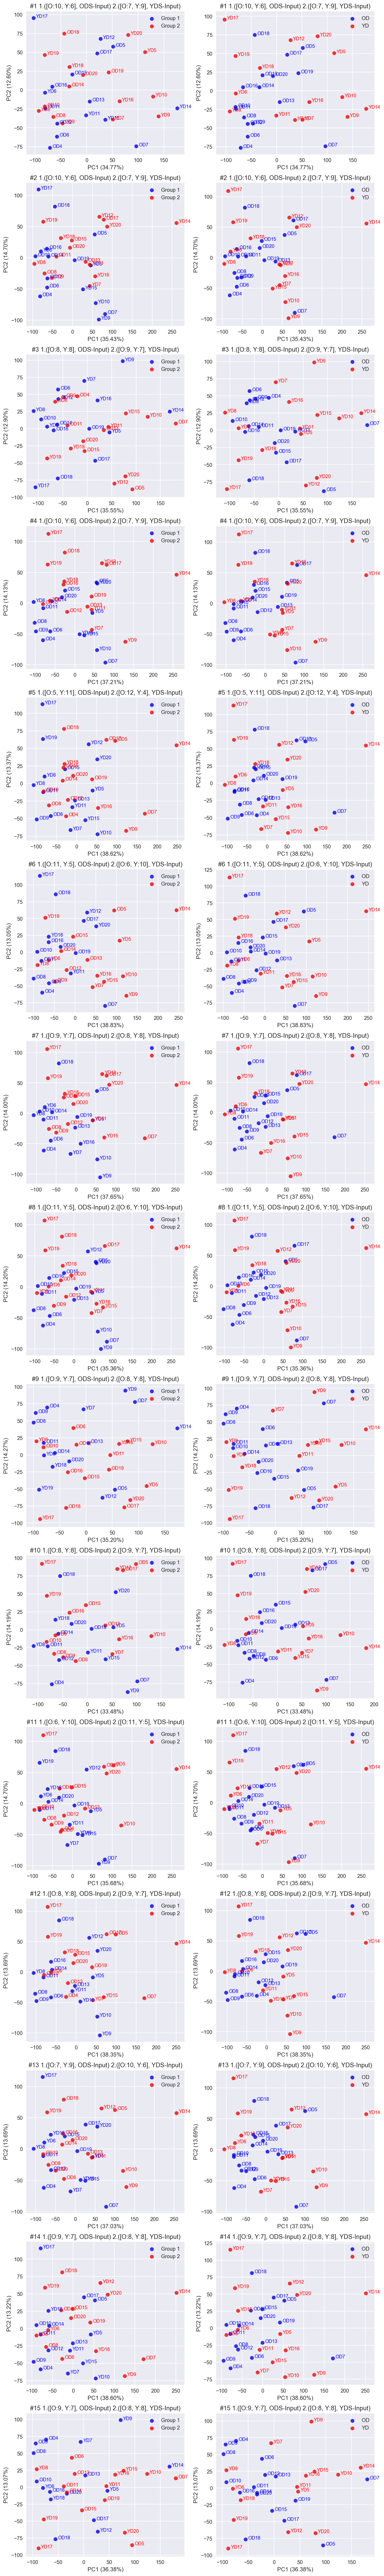

In [13]:
ODS, YDS, OYDS = split_by_age(rpms)

print("All donors: {}, O:{}, Y:{}".format(
    len(OYDS),
    np.sum([l.startswith('OD') for l in OYDS]),
    np.sum([l.startswith('YD') for l in OYDS])))

random_donors_split(rpms, OYDS, make_rpkm_diff_score, None, n_iter=15, seed=10)        

# RPM Input Histograms

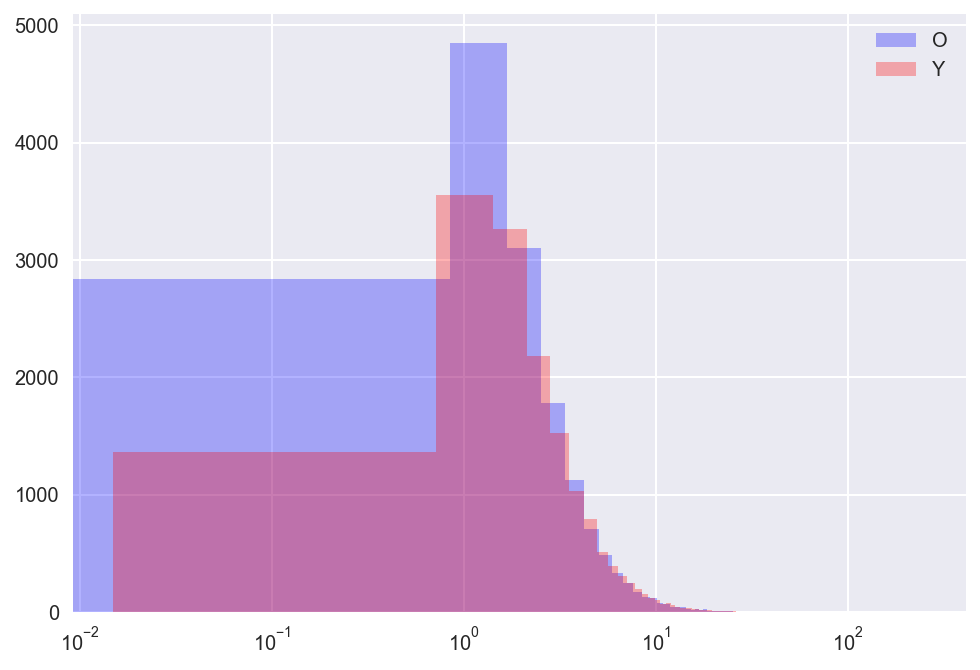

In [14]:
plt.hist(rpms[OD_input], bins=300, label="O", color='blue', alpha=0.3)
plt.hist(rpms[YD_input], bins=300, label="Y", color='red', alpha=0.3,)
plt.xscale("log")
plt.legend()
plt.show()

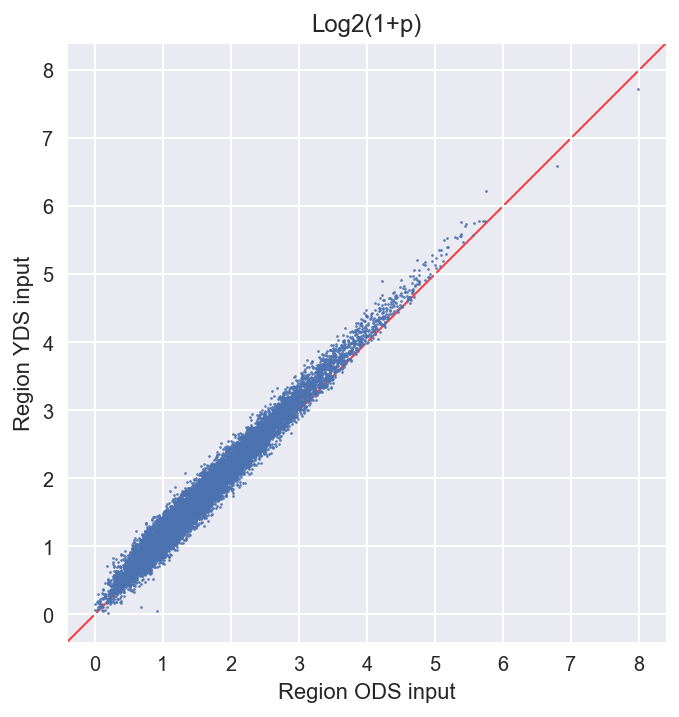

In [15]:
ax = plt.subplot()
ax.scatter(np.log1p(rpms[OD_input])/np.log(2), np.log1p(rpms[YD_input])/np.log(2), alpha=.9, s=1)
ax.set_xlabel("Region ODS input")
ax.set_ylabel("Region YDS input")
ax.set_title("Log2(1+p)")
# x = y
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0, lw=1) #, ls='dotted')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [16]:
mask = np.multiply(rpms[OD_input] != 0, rpms[YD_input] != 0)
print("Zeros in O input or Y input: ", np.sum(~mask))

Zeros in O input or Y input:  2


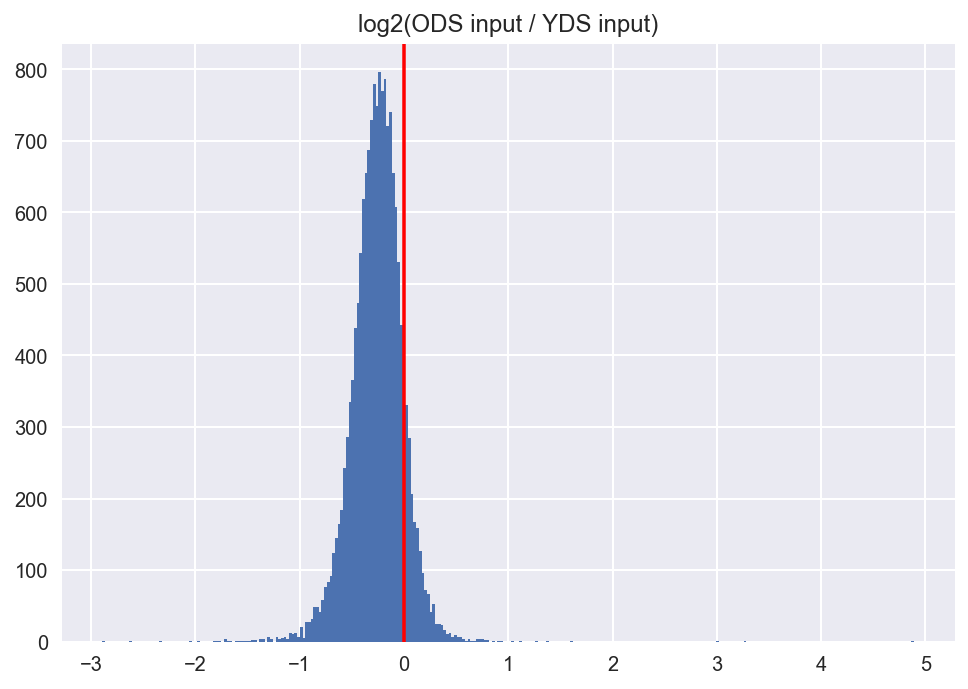

In [17]:
plt.hist(np.log2(rpms[OD_input][mask]/rpms[YD_input][mask]), bins=300)
plt.axvline(0, color="r")
plt.title("log2(ODS input / YDS input)")
plt.show()

Input trend: ODS < YDS

# Score: DiffBind

Seems no diff in signal, PCA separation due to using pulled input without replicates

In [18]:
file_id = "YO_macs_broad_0.1_150"
# file_id = "PEAKS_UCSC_CGI"

raw_path = "/Users/romeo/tmp/artyomov_lab_aging/k4me1/k4me1_20vs20_reseq_bams_unique/coverages/{0}/{0}_raw.tsv".format(file_id)
raw = pd.read_csv(raw_path, sep="\t")

sizes = pd.read_csv("/Users/romeo/tmp/artyomov_lab_aging/k4me1/k4me1_20vs20_reseq_bams_unique/tags_150/sizes.tsv",
                    sep="\t", names=["name", "size"], index_col="name")

OD_input = "OD_input_unique"
YD_input = "YD_input_unique"

## Code [!!!!!!!!!!!!!!!]

In [19]:
# data - Data df: ranges x donors
# donor_cols - required donors columns names
# input_col - column name with input
# sizes - donors sizes
def make_diffbind_scores(data, donor_cols, input_col, sizes):    
    i_lib_size = sizes.loc[input_col, "size"]
    i_data = data[input_col]
    
    df = pd.DataFrame()
    for d in donor_cols:
        d_lib_size = sizes.loc[d, "size"]
        scale = min(1, d_lib_size / i_lib_size)
        scores = data[d] - np.ceil(i_data * scale)
        scores[scores < 1] = 1
#         scores = scores / csize   #XXX: not critical for PCA
        min_s = scores.min()
        #TODO: scores[i] / s[i]
        df[d] = (scores - min_s) / (scores.max() - min_s)
#         df[c] = scores
        
    return df   

In [38]:
def describe_diffbind_score(coverage, donor, donor_input, sizes):
    i_lib_size = sizes.loc[donor_input, "size"]
    d_lib_size = sizes.loc[donor, "size"]
    scale = min(1, d_lib_size / i_lib_size)
    
    scored_diff = coverage[donor] - np.ceil(coverage[donor_input] * scale)
    def format_pnt(k,n):
        return "{} of {} ({:.1%})".format(k, n, k / n)
    print("Scores diff < 0:", format_pnt(np.sum(scored_diff < 0), len(scored_diff)))
    print("Scores diff < 1:", format_pnt(np.sum(scored_diff < 1), len(scored_diff)))
        
    scores = scored_diff.copy()
    scores[scores < 1] = 1
    
    min_s = scores.min()
    scores_norm = (scores - min_s) / (scores.max() - min_s)
        
    plt.figure(figsize=(10,10))

    ax = plt.subplot(2,2,1)
    ax.hist(scored_diff, bins=100)
    ax.set_title("{} - Input*Scale".format(donor))
    ax.set_xscale("log")

    ax = plt.subplot(2,2,2)
    ax.hist(scored_diff[scored_diff < 1000], bins=100)
    ax.set_title("{} - Input*Scale: values < 1000".format(donor))
    #ax.vlines(1, 0, 30000, color="red")
    ax.set_xscale("log")

    ax = plt.subplot(2,2,3)
    ax.hist(scores[scores < 1000], bins=200)
    ax.set_title("min(1, {} - Input*Scale): values < 1000".format(donor))
    ax.set_xscale("log")

    ax = plt.subplot(2,2,4)
    ax.hist(scores_norm, bins=100)
    ax.set_title("Lin. norm scores".format(donor))
    ax.set_xscale("log")

    plt.show()

## Score Histogram

Scores diff < 0: 14856 of 159684 (9.3%)
Scores diff < 1: 18747 of 159684 (11.7%)


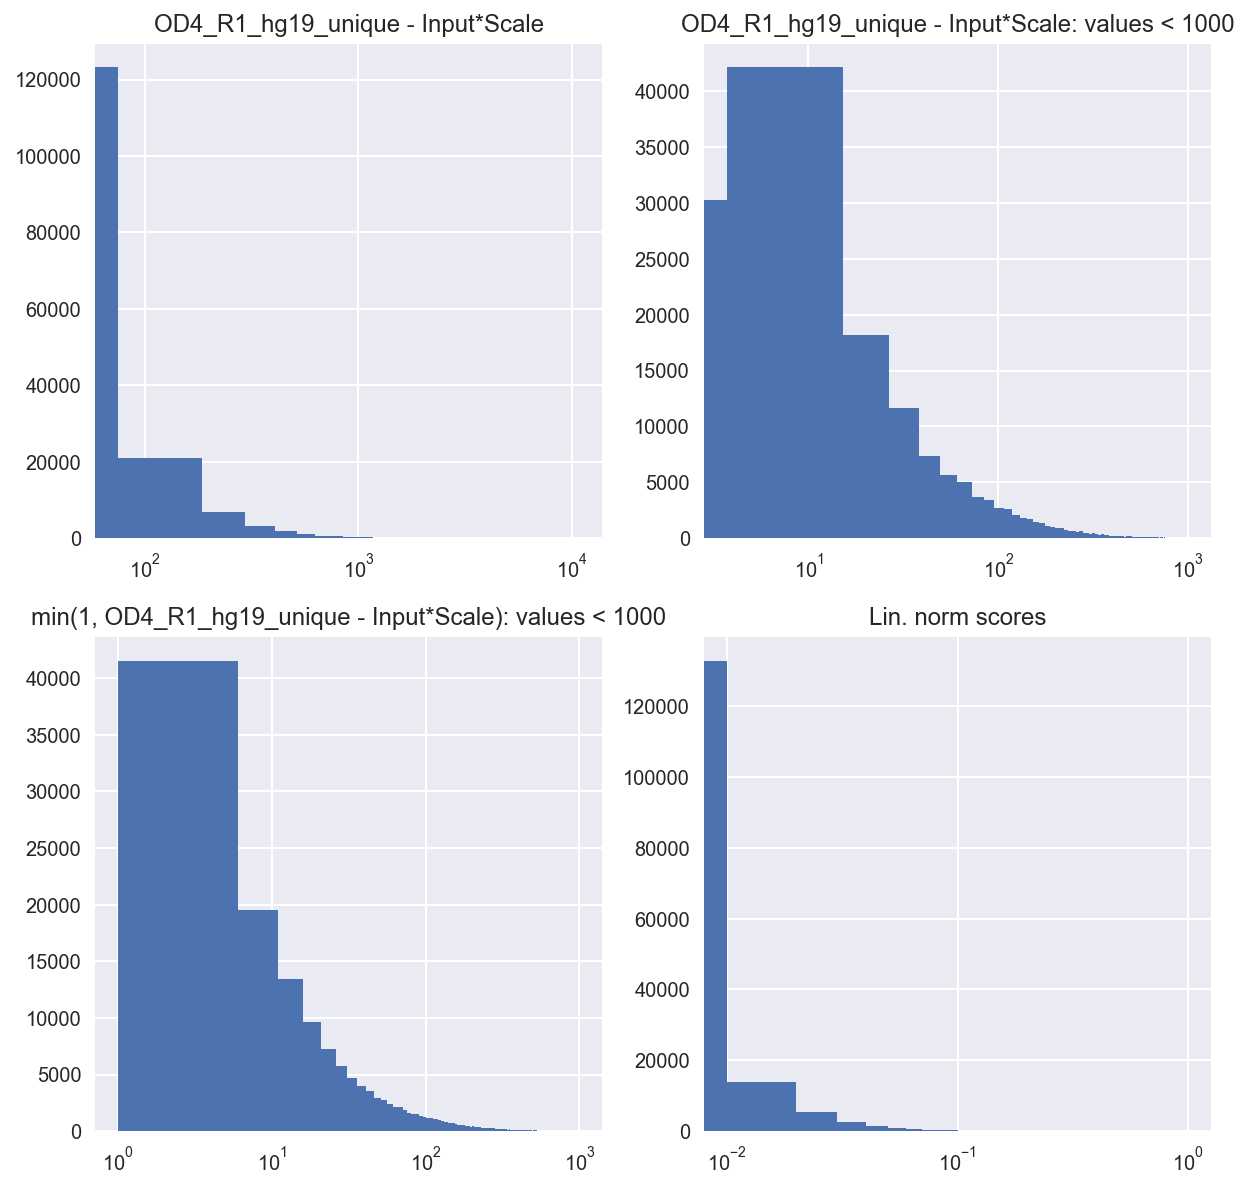

In [39]:
describe_diffbind_score(raw, "OD4_R1_hg19_unique", OD_input, sizes)

## PCA

PCA components:  (32, 2)


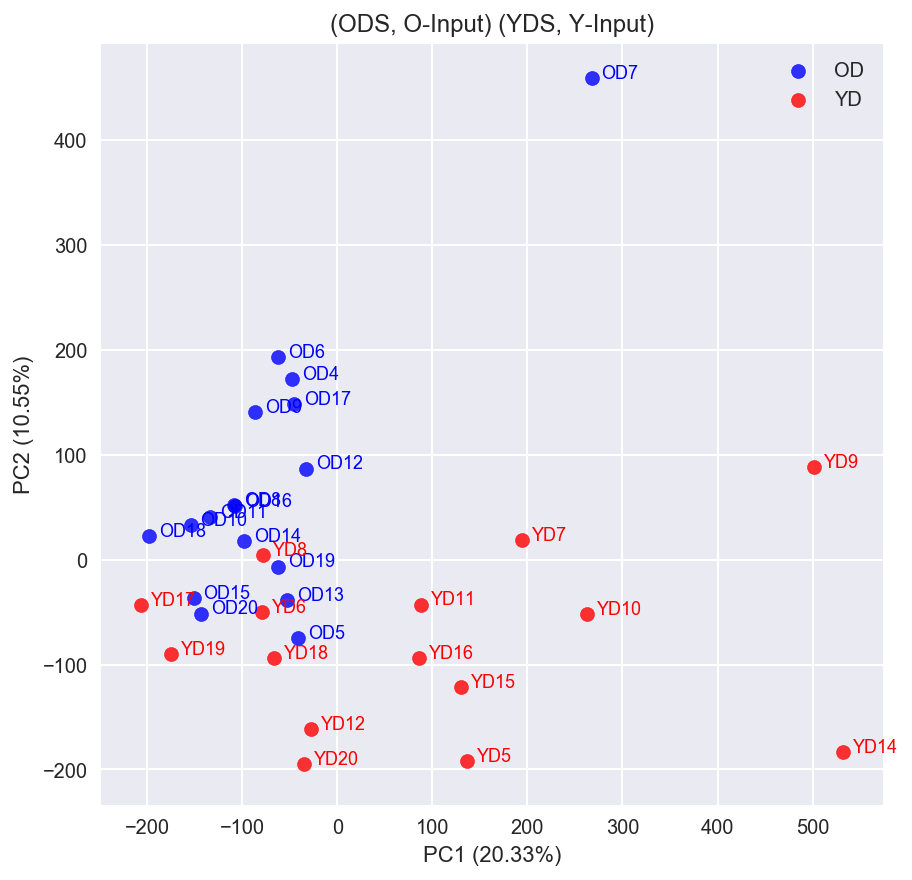

PCA components:  (32, 2)


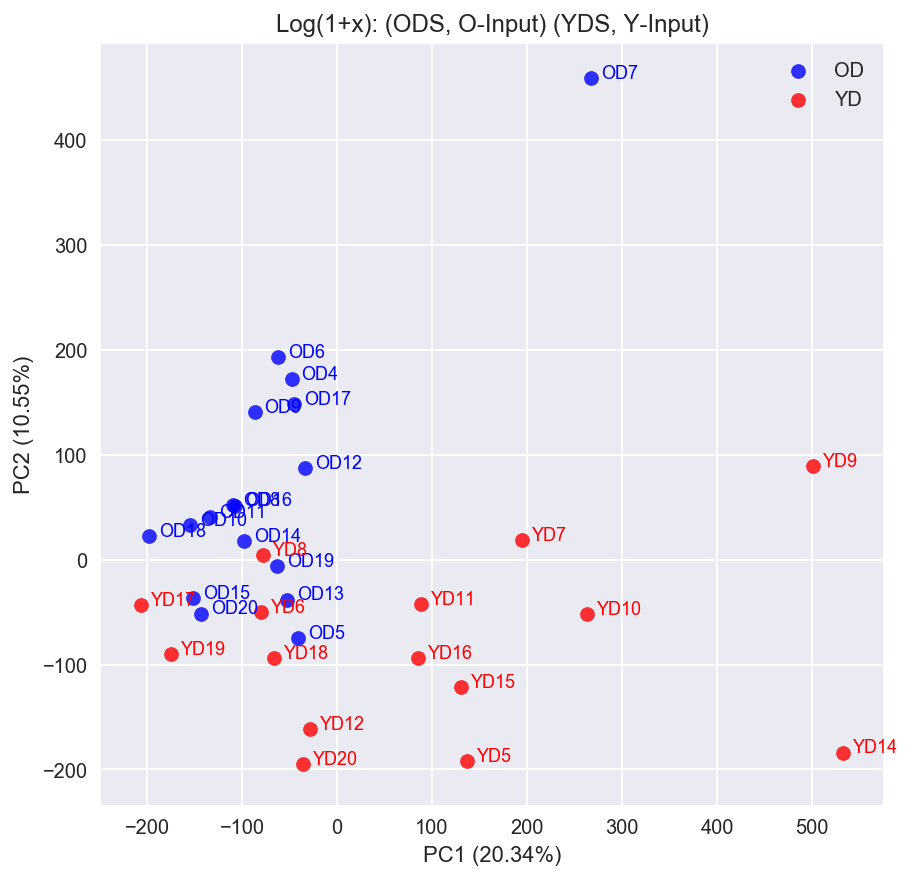

In [22]:
ODS, YDS, OYDS = split_by_age(raw)
signal = pd.concat((make_diffbind_scores(raw, ODS, OD_input, sizes), 
                    make_diffbind_scores(raw, YDS, YD_input, sizes)), axis=1).T

signal_pca(signal, "(ODS, O-Input) (YDS, Y-Input)")
signal_pca(np.log1p(signal), "Log(1+x): (ODS, O-Input) (YDS, Y-Input)")

PCA components:  (31, 2)


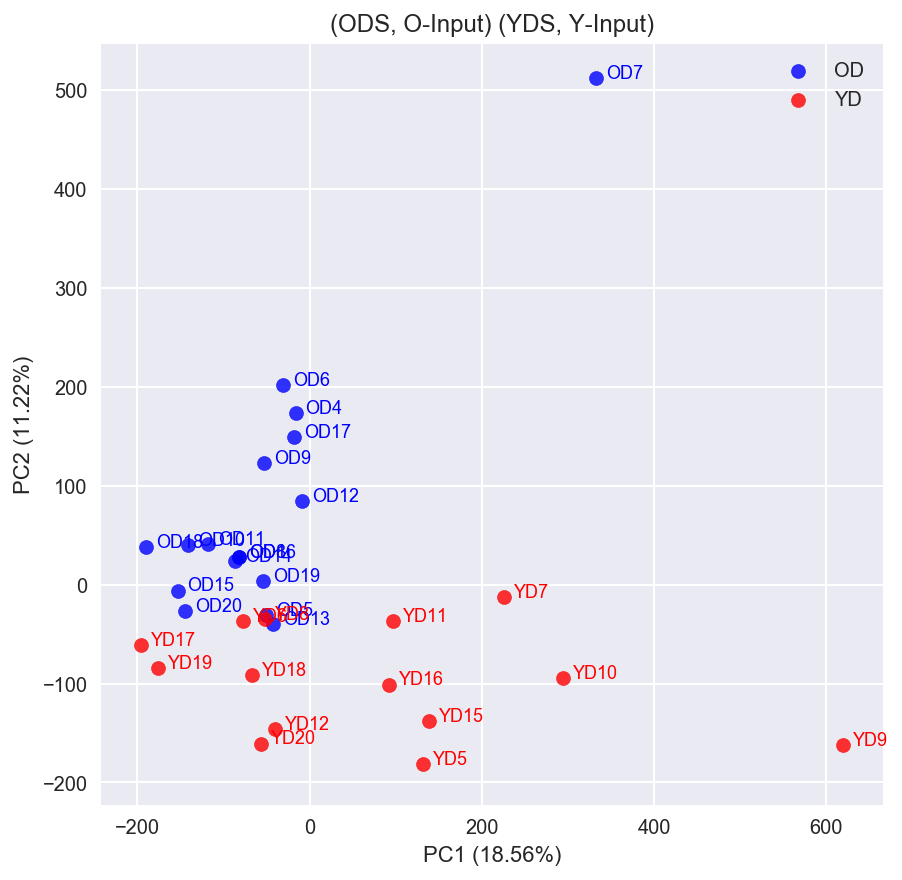

In [23]:
ODS, YDS, OYDS = split_by_age(raw, "YD14")
signal = pd.concat((make_diffbind_scores(raw, ODS, OD_input, sizes), 
                    make_diffbind_scores(raw, YDS, YD_input, sizes)), axis=1).T

signal_pca(signal, "(ODS, O-Input) (YDS, Y-Input)")
#signal_pca(np.log1p(signal), "Log(1+x): (ODS, O-Input) (YDS, Y-Input)")

PCA components:  (29, 2)


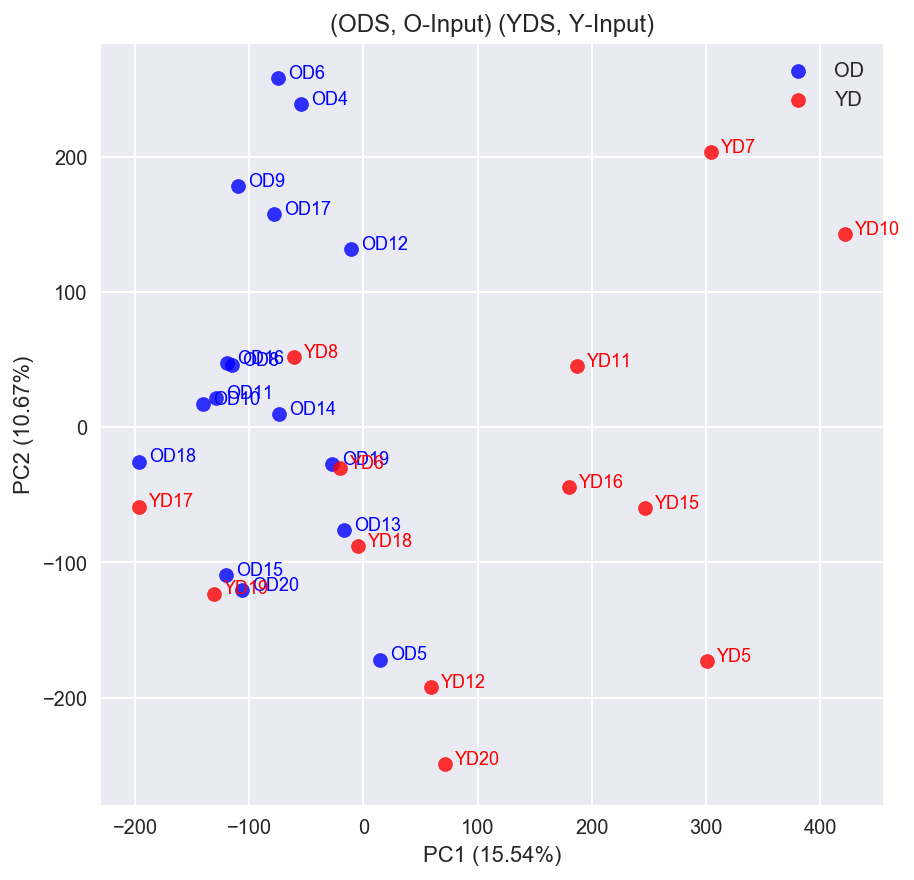

In [24]:
ODS, YDS, OYDS = split_by_age(raw, "YD14", "YD9", "OD7")
signal = pd.concat((make_diffbind_scores(raw, ODS, OD_input, sizes), 
                    make_diffbind_scores(raw, YDS, YD_input, sizes)), axis=1).T

signal_pca(signal, "(ODS, O-Input) (YDS, Y-Input)")
# signal_pca(np.log1p(signal), "Log(1+x): (ODS, O-Input) (YDS, Y-Input)")

## PCA: Swap Y<->O Input

PCA components:  (32, 2)


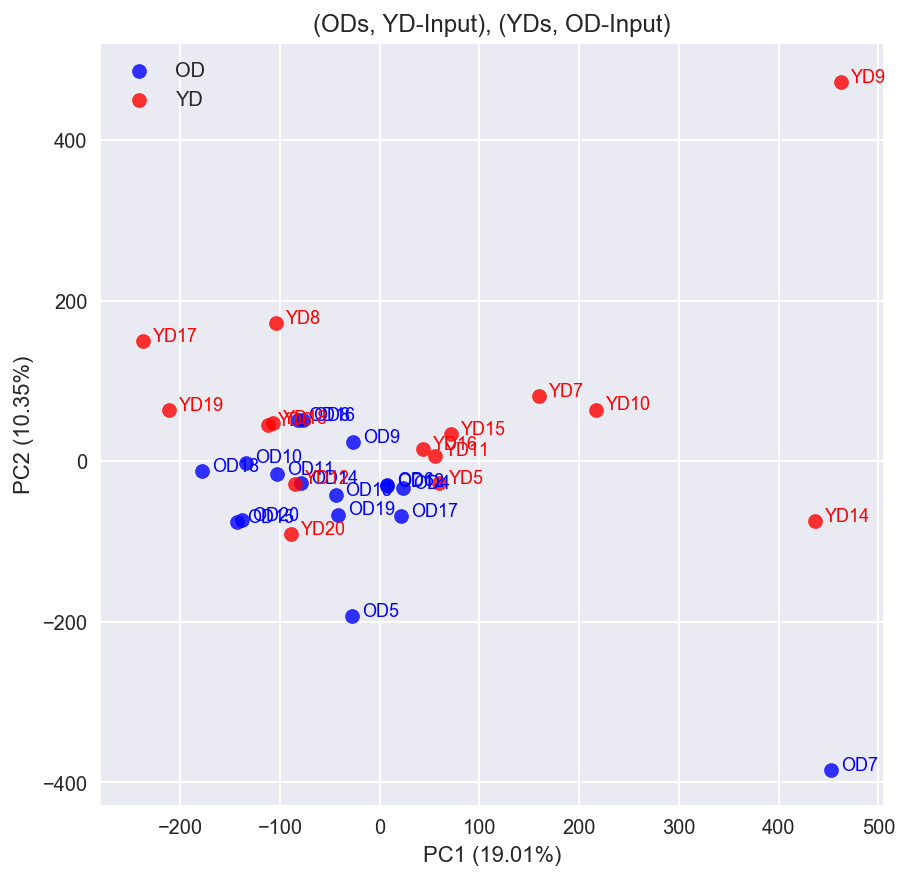

In [25]:
ODS, YDS, OYDS = split_by_age(raw)
signal = pd.concat((make_diffbind_scores(raw, ODS, YD_input, sizes), 
                    make_diffbind_scores(raw, YDS, OD_input, sizes)), axis=1)


signal_pca(signal.T, "(ODs, YD-Input), (YDs, OD-Input)")
#signal_pca(np.log1p(signal.T), "Log(1+x): (ODs, YD-Input), (YDs, OD-Input)")

PCA components:  (31, 2)


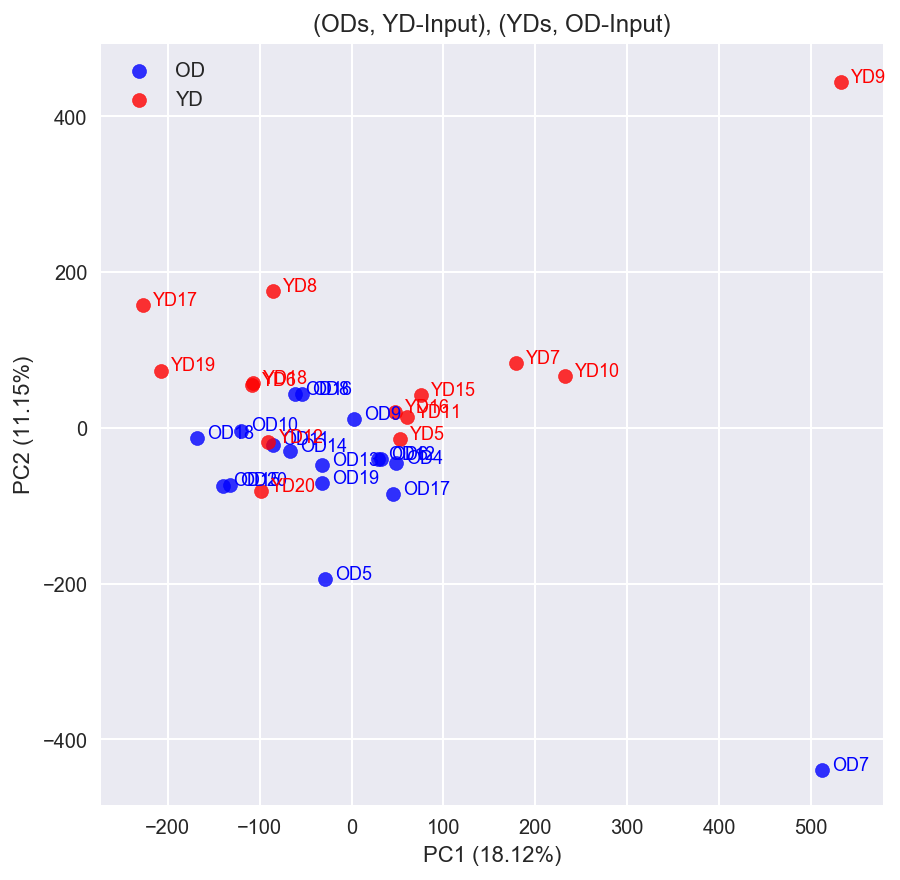

In [26]:
ODS, YDS, OYDS = split_by_age(raw, "YD14")
signal = pd.concat((make_diffbind_scores(raw, ODS, YD_input, sizes), 
                    make_diffbind_scores(raw, YDS, OD_input, sizes)), axis=1)


signal_pca(signal.T, "(ODs, YD-Input), (YDs, OD-Input)")

PCA components:  (29, 2)


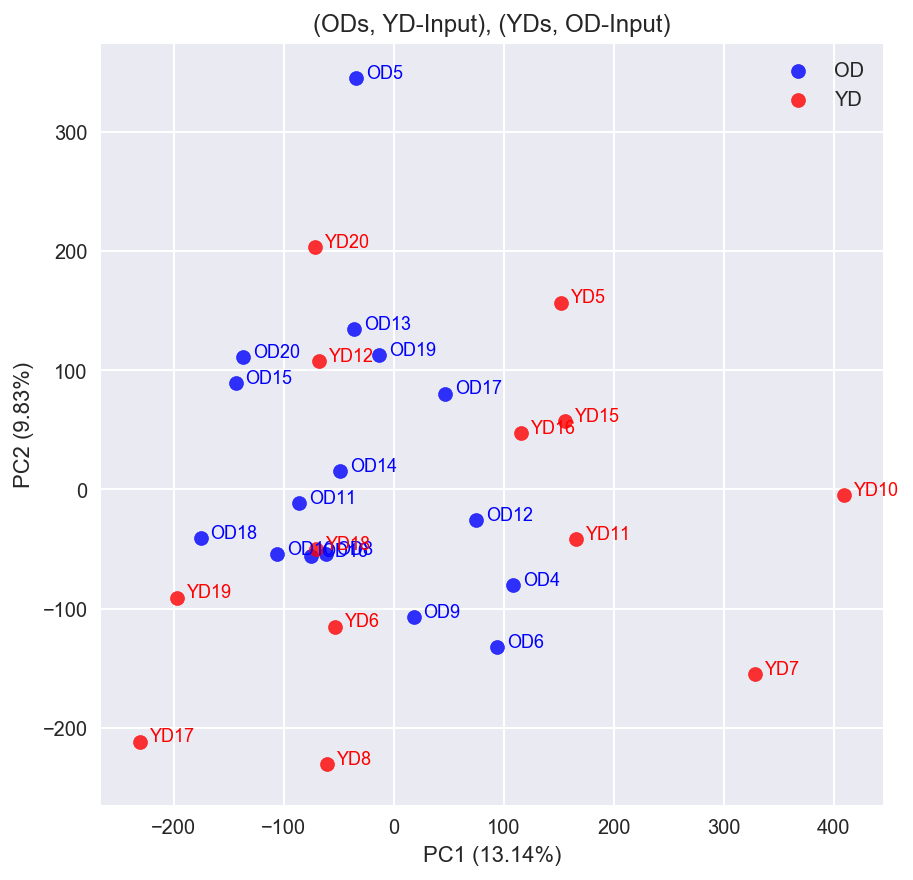

In [27]:
ODS, YDS, OYDS = split_by_age(raw, "YD14", "YD9", "OD7")
signal = pd.concat((make_diffbind_scores(raw, ODS, YD_input, sizes), 
                    make_diffbind_scores(raw, YDS, OD_input, sizes)), axis=1)


signal_pca(signal.T, "(ODs, YD-Input), (YDs, OD-Input)")

## PCA: Mean (OD Input, YD input)

PCA components:  (32, 2)


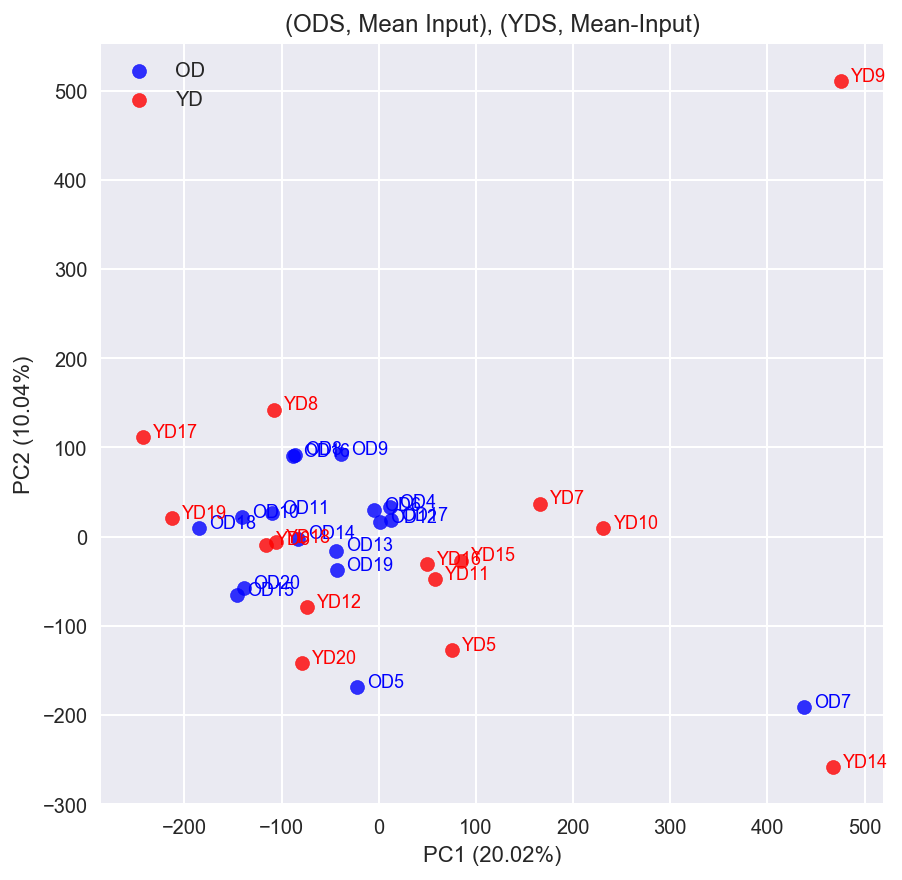

In [28]:
ODS, YDS, OYDS = split_by_age(raw)

OY_mean_input = 'OYD_mean_input_unique'
raw[OY_mean_input] = (raw[OD_input] + raw[YD_input]) / 2 
sizes.loc[OY_mean_input, :] = (sizes.loc[OD_input, :] + sizes.loc[YD_input,:])/2

signal = pd.concat((make_diffbind_scores(raw, ODS, OY_mean_input, sizes), 
                    make_diffbind_scores(raw, YDS, OY_mean_input, sizes)), axis=1)


signal_pca(signal.T, "(ODS, Mean Input), (YDS, Mean-Input)")
# signal_pca(np.log1p(signal.T), "log(1+x): (ODS, Mean Input), (YDS, Mean-Input)")

PCA components:  (29, 2)


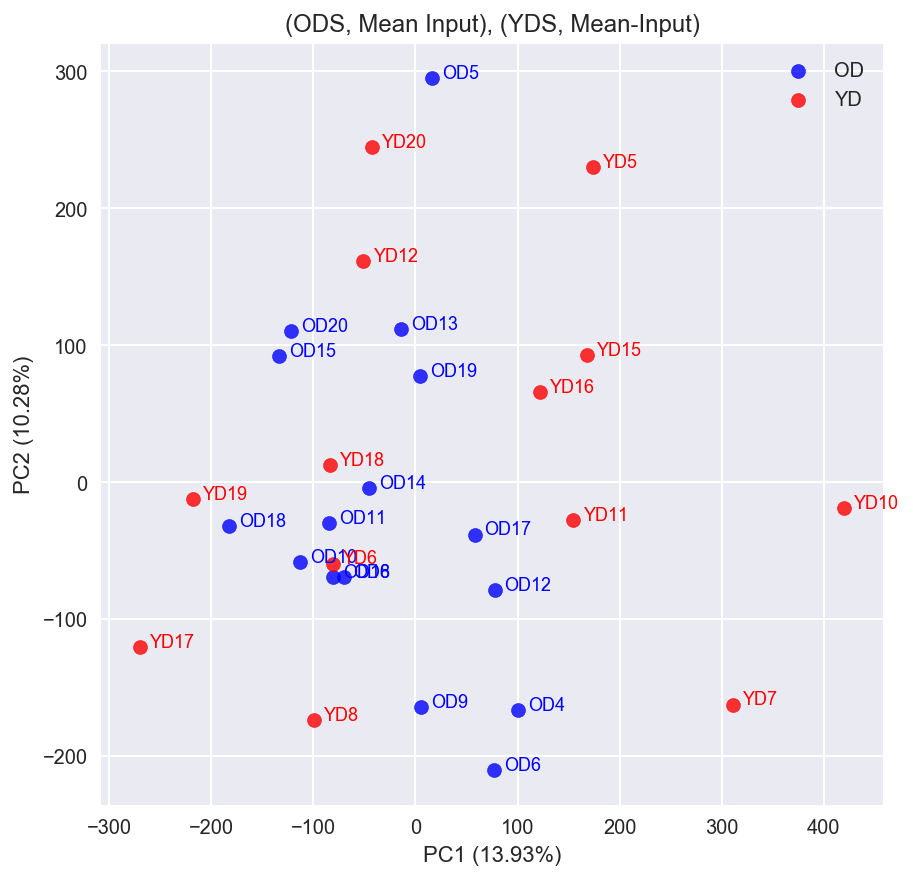

In [29]:
ODS, YDS, OYDS = split_by_age(raw, "YD14", "YD9", "OD7")

OY_mean_input = 'OYD_mean_input_unique'
raw[OY_mean_input] = (raw[OD_input] + raw[YD_input]) / 2 
sizes.loc[OY_mean_input, :] = (sizes.loc[OD_input, :] + sizes.loc[YD_input,:])/2

signal = pd.concat((make_diffbind_scores(raw, ODS, OY_mean_input, sizes), 
                    make_diffbind_scores(raw, YDS, OY_mean_input, sizes)), axis=1)


signal_pca(signal.T, "(ODS, Mean Input), (YDS, Mean-Input)")
# signal_pca(np.log1p(signal.T), "log(1+x): (ODS, Mean Input), (YDS, Mean-Input)")

## PCA: Pooled input

In [30]:
#todo

## PCA: Two Random donors subgroups assigned to O and Y inputs:

PCA components:  (32, 2)


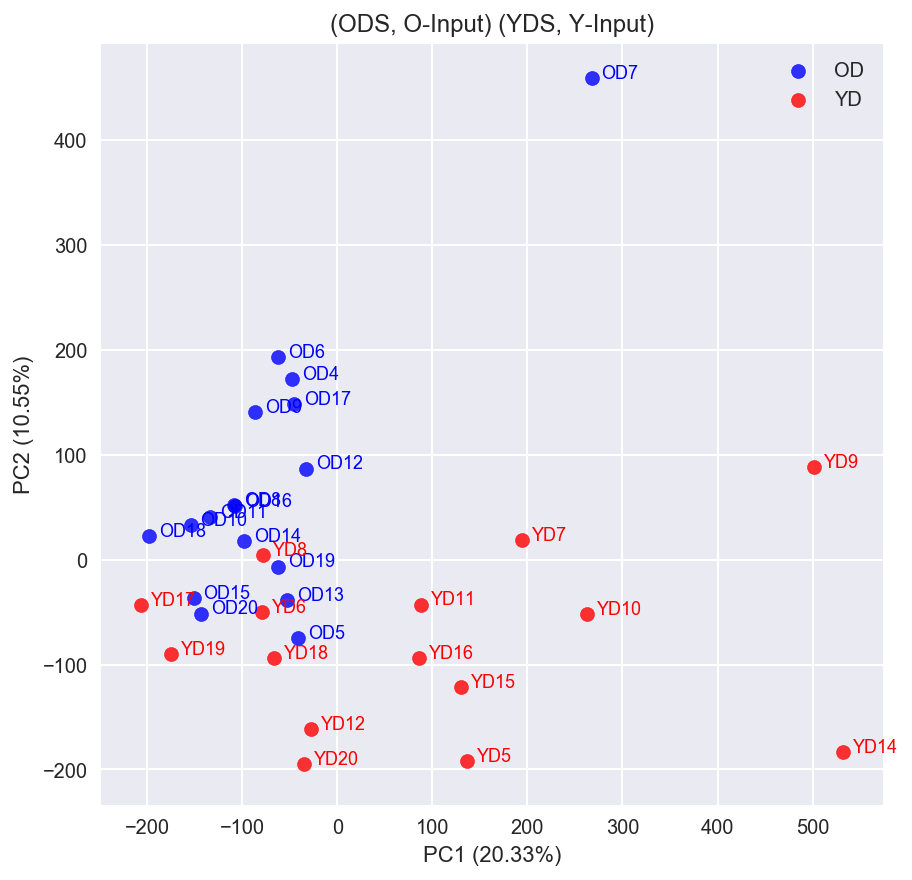

In [31]:
ODS, YDS, OYDS = split_by_age(raw)

# Let's recall ODS vs YDS PCA:
signal = pd.concat((make_diffbind_scores(raw, ODS, OD_input, sizes), 
                    make_diffbind_scores(raw, YDS, YD_input, sizes)), axis=1).T

signal_pca(signal, "(ODS, O-Input) (YDS, Y-Input)")
#signal_pca(np.log1p(signal), "Log(1+x): (ODS, O-Input) (YDS, Y-Input)")

All donors: 31, O:17, Y:14
======================== 0/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 1/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 2/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 3/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 4/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 5/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 6/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 7/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
======================== 8/15 ======================== 
PCA components:  (31, 2)
PCA components:  (31, 2)
===================

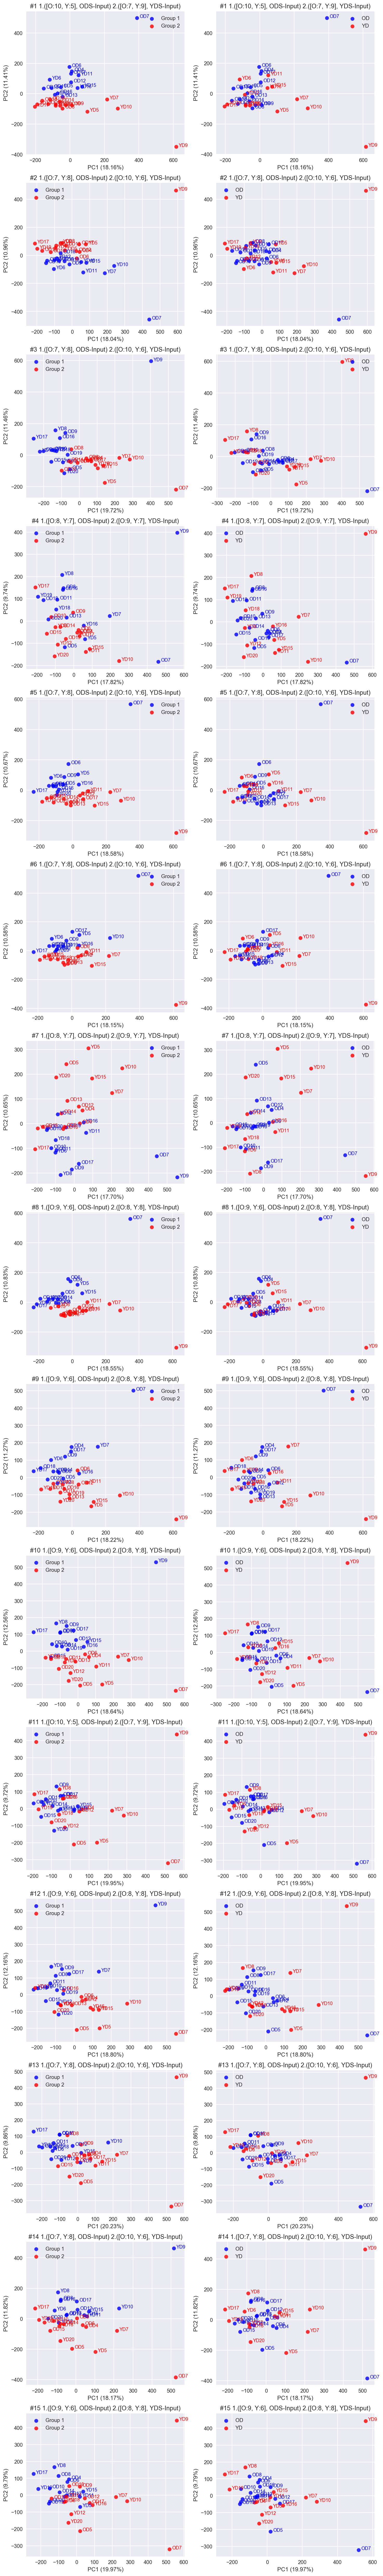

In [32]:
# Donors w/o outliers: YD14
ODS, YDS, OYDS = split_by_age(raw, "YD14")

print("All donors: {}, O:{}, Y:{}".format(
    len(OYDS),
    np.sum([l.startswith('OD') for l in OYDS]),
    np.sum([l.startswith('YD') for l in OYDS])))

random_donors_split(raw, OYDS, make_diffbind_scores, sizes, n_iter=15, seed=10)        

All donors: 29, O:16, Y:13
======================== 0/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 1/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 2/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 3/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 4/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 5/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 6/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 7/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
======================== 8/15 ======================== 
PCA components:  (29, 2)
PCA components:  (29, 2)
===================

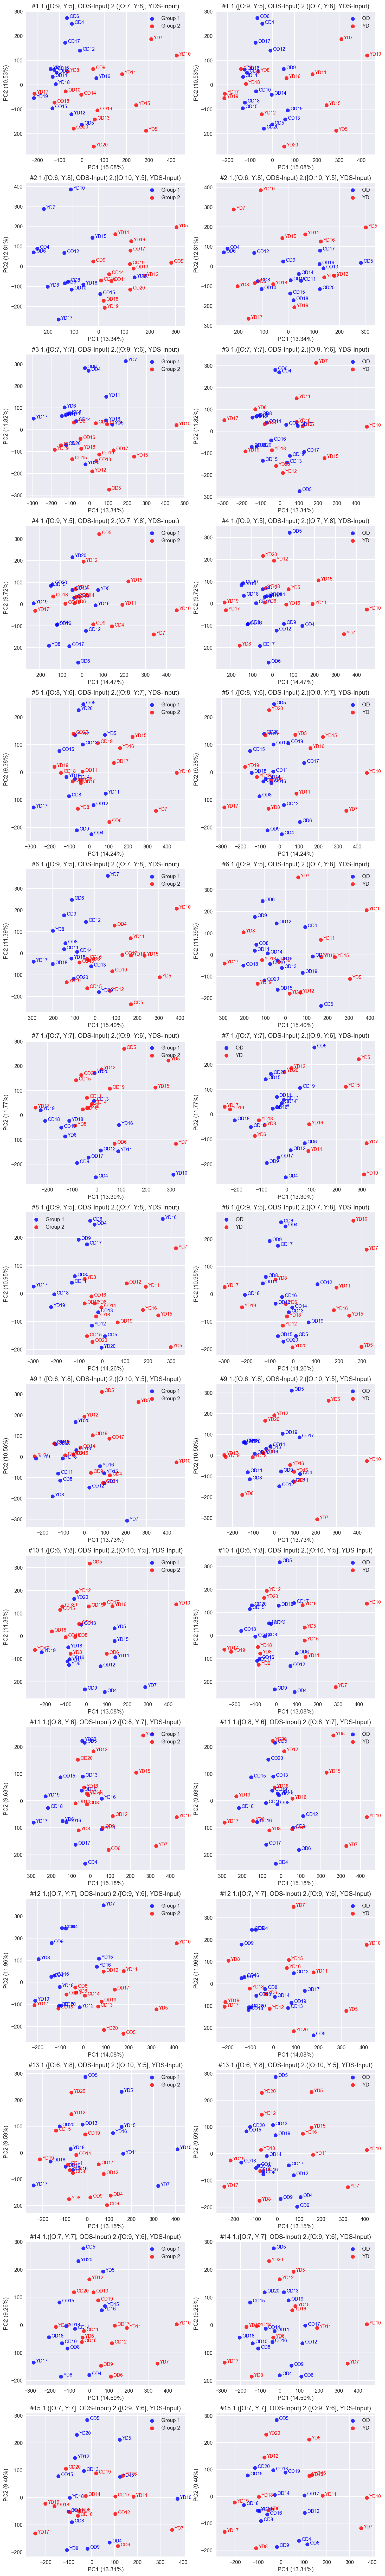

In [33]:
ODS, YDS, OYDS = split_by_age(raw, "YD14", "YD9", "OD7")

print("All donors: {}, O:{}, Y:{}".format(
    len(OYDS),
    np.sum([l.startswith('OD') for l in OYDS]),
    np.sum([l.startswith('YD') for l in OYDS])))

random_donors_split(raw, OYDS, make_diffbind_scores, sizes, n_iter=15, seed=10)        

# TODO: BigWig rpm bases scores